In [27]:
# analysis
import pandas as pd
import numpy as np
from scipy import stats

# visualization
import matplotlib.pyplot as plt
# import seaborn as sns
# import plotly.express as px
# import plotly.figure_factory as ff

# preprocessingn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# metrics
from sklearn.metrics import roc_auc_score

# model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier

from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import warnings

warnings.filterwarnings('ignore')

In [28]:
# loading datasets
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
sub = pd.read_csv("./sample_submission.csv")
# original = pd.read_csv("/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")

train.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,80,0,31,0,3,31,14,4,10,1


In [29]:
# # making the orignal similar to train and test
# # renaming EmployeeNumber with id
# original.rename(columns={"EmployeeNumber": "id"}, inplace=True)
# # rearranging the order of columns similar to train
# original = original[train.columns]

# original['Attrition'] = original['Attrition'].map(lambda x: 0 if x=="No" else 1)

In [30]:
# checking categorires in each qualitive feature
cat_cols = train.select_dtypes(include=['object']).columns

print("TRAINING DATASET:")
for cat_col in cat_cols:
    print(f"{cat_col}: {train[cat_col].unique()}")
    
print("\nTEST DATASET:")
for cat_col in cat_cols:
    print(f"{cat_col}: {test[cat_col].unique()}")

TRAINING DATASET:
BusinessTravel: ['Travel_Frequently' 'Travel_Rarely' 'Non-Travel']
Department: ['Research & Development' 'Sales' 'Human Resources']
EducationField: ['Medical' 'Other' 'Marketing' 'Life Sciences' 'Technical Degree'
 'Human Resources']
Gender: ['Male' 'Female']
JobRole: ['Laboratory Technician' 'Sales Representative' 'Sales Executive'
 'Healthcare Representative' 'Manager' 'Manufacturing Director'
 'Research Scientist' 'Human Resources' 'Research Director']
MaritalStatus: ['Married' 'Divorced' 'Single']
Over18: ['Y']
OverTime: ['Yes' 'No']

TEST DATASET:
BusinessTravel: ['Non-Travel' 'Travel_Rarely' 'Travel_Frequently']
Department: ['Research & Development' 'Sales' 'Human Resources']
EducationField: ['Medical' 'Marketing' 'Life Sciences' 'Technical Degree' 'Other'
 'Human Resources']
Gender: ['Male' 'Female']
JobRole: ['Laboratory Technician' 'Sales Executive' 'Research Scientist'
 'Healthcare Representative' 'Manager' 'Human Resources'
 'Sales Representative' 'Manufact

In [31]:
train.drop(columns=['Over18', 'StandardHours', 'EmployeeCount'], inplace=True)
test.drop(columns=['Over18','StandardHours', 'EmployeeCount'], inplace=True)

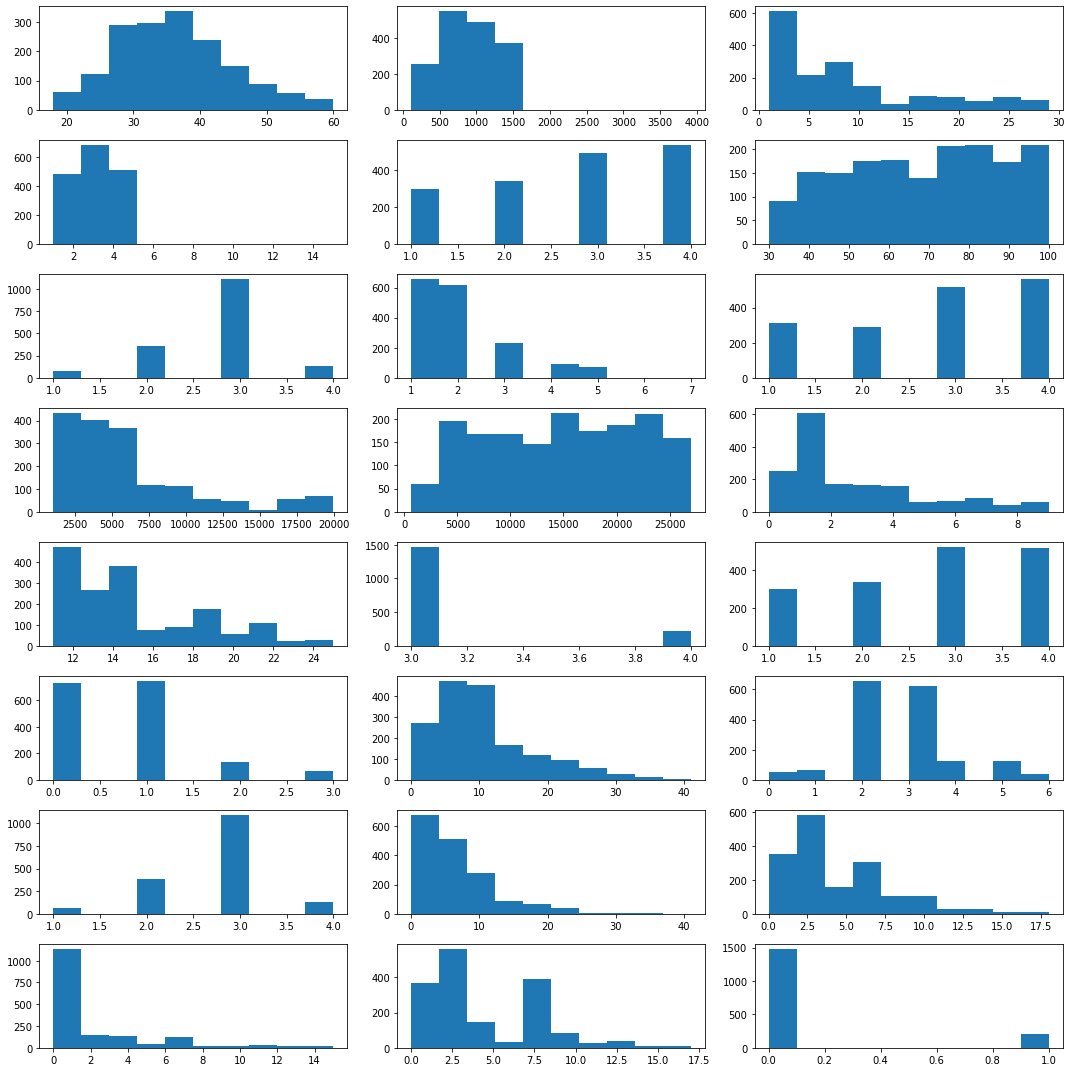

In [32]:
# first lets check out their distribtuion of all the observationn in train set
quan_cols = train.select_dtypes(include=[int, float]).drop(columns=['id']).columns

plt.figure(figsize=(15, 15))
for index, col in enumerate(quan_cols):
    plt.subplot(8, 3, index+1)
    plt.hist(data=train, x=col)
    
plt.tight_layout()

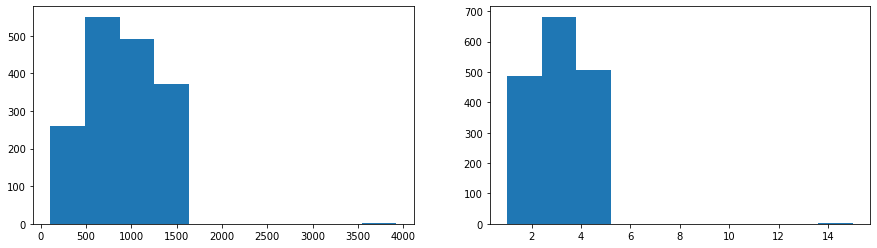

In [33]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.hist(data=train, x='DailyRate')
plt.subplot(1, 2, 2)
plt.hist(data=train, x='Education')
plt.show()

In [34]:
train = train[(train['DailyRate'] < 2000) & (train['Education'] < 10)]


In [35]:
X = train.drop(columns=['Attrition', 'id'])
y = train['Attrition']

In [36]:
X

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,4,Male,42,...,3,2,1,10,2,3,10,0,7,8
1,35,Travel_Rarely,921,Sales,8,3,Other,1,Male,46,...,3,4,1,4,3,3,4,2,0,3
2,32,Travel_Rarely,718,Sales,26,3,Marketing,3,Male,80,...,3,4,2,4,3,3,3,2,1,2
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,3,Female,40,...,3,3,0,15,1,1,6,0,0,2
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,2,Female,37,...,3,3,0,31,0,3,31,14,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,30,Travel_Rarely,945,Sales,1,3,Life Sciences,4,Female,73,...,3,2,0,10,2,4,10,0,0,8
1673,32,Travel_Rarely,1303,Research & Development,2,3,Life Sciences,1,Male,48,...,3,4,1,10,3,4,4,2,1,3
1674,29,Travel_Frequently,1184,Human Resources,24,3,Human Resources,2,Male,36,...,3,3,0,1,2,3,1,0,0,0
1675,36,Travel_Rarely,441,Sales,9,2,Marketing,2,Male,48,...,4,3,2,10,3,2,10,3,0,8


In [37]:
# a function which would return all transformed data set ready for model training and validation
def get_train_valid(X_train, X_test, round=False):

# pipelining the whole process of encoding and scaling
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X_train.select_dtypes(include=['int', 'float']).columns
    
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))])
    numerical_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

    ct_cls = ColumnTransformer(transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)])

    X_train = ct_cls.fit_transform(X_train)
    X_test = ct_cls.transform(X_test)

# if round = True numerical values will be round to 4
    if round:
    # rounding the values tot 4 decimals so that they take less time to train
        X_train = np.round(X_train, decimals=4)
        X_test = np.round(X_test, decimals=4)

    return X_train, X_test

In [38]:
X_train, X_test = get_train_valid(X, test)
X_train.shape

(1675, 44)

In [40]:
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    "SVC" : SVC(random_state=0, probability=True), 
    "RandomForest" : RandomForestClassifier(random_state=0),
    "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'),
    "NaiveBayes": GaussianNB(),
    'extra': ExtraTreesClassifier()
}

In [41]:
model_scores = pd.DataFrame({"classifier": classifiers.keys(), "mean_training_score": np.zeros(len(classifiers)),
                             'mean_validation_score': np.zeros(len(classifiers)), 
                            'mean_train_time': np.zeros(len(classifiers))})
index = 0
for model_name, model in classifiers.items():
    history = cross_validate(model, X_train, y, scoring='roc_auc', return_train_score=True, n_jobs=-1)
    
    model_scores.loc[index, 'mean_training_score']= history['train_score'].mean()
    model_scores.loc[index, 'mean_validation_score']= history['test_score'].mean()
    model_scores.loc[index, 'mean_train_time']= history['fit_time'].mean()
        
    index += 1

In [42]:
model_scores


,classifier,mean_training_score,mean_validation_score,mean_train_time
0,LogisticRegression,0.860914,0.818441,0.007129
1,KNN,0.904347,0.626771,0.000418
2,SVC,0.962934,0.765373,0.155069
3,RandomForest,1.000000,0.827517,0.132180
4,XGBoost,1.000000,0.817254,0.273013
5,NaiveBayes,0.777257,0.751203,0.000688
6,extra,1.000000,0.808093,0.103122


In [43]:
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
#    "SVC" : SVC(random_state=0, probability=True), 
    "RandomForest" : RandomForestClassifier(random_state=0),
    "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss', verbosity=0),
#     "LGBM" : LGBMClassifier(random_state=0),
#    "CatBoost" : CatBoostClassifier(random_state=0, verbose=False)
    'extra': ExtraTreesClassifier(random_state=0,)
}



LR_grid = {'penalty': ['l2', 'elasticnet'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 0.1],
           'max_iter': [50, 100, 150],
           'solver': ['lbfgs', 'liblinear']}


RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300, 500],
        'max_depth': [4, 6, 8, 10, 12],
        'criterion' : ["gini", "entropy"]}

xgb_grid = {'n_estimators': [50, 100, 150, 200, 300],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15, 0.01],
        'max_leaves': [1, 2, 3, 0]}

ext_grid = {'max_depth': [4, 8, 12],
        'max_leaf_nodes': [1, 2, 3, 4]}


grid = {
    "LogisticRegression" : LR_grid,
    #"SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : xgb_grid,
#     "LGBM" : boosted_grid,
    'extra': ext_grid
}

In [44]:
import time
grid_cvs = {}

for key, classifier in classifiers.items():
    print('Model:', key)
    start= time.time()

#     change the number of n_iter for more combination and trails for each model but it would take more time
    grid_cv = RandomizedSearchCV(classifier, grid[key], n_iter=10, n_jobs=-1, scoring='roc_auc',
                             return_train_score=True)
    grid_cv.fit(X_train, y)

    end = time.time()

    time_taken = (end - start)/60
    print(f'model : {key} training time: {time_taken}')
    index += 1
    
    grid_cvs[f'{key}'] = grid_cv

Model: LogisticRegression
model : LogisticRegression training time: 0.0014840324719746908
Model: RandomForest
model : RandomForest training time: 0.04686366717020671
Model: XGBoost
model : XGBoost training time: 0.06149688164393107
Model: extra
model : extra training time: 0.008115851879119873


In [45]:
for index, model_name in enumerate(classifiers.keys()):
    print(f"{model_name}-> best_params: {grid_cvs[model_name].best_params_}, best_score:{grid_cvs[model_name].best_score_}")

LogisticRegression-> best_params: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'C': 1.25}, best_score:0.8181525423728813
RandomForest-> best_params: {'n_estimators': 250, 'max_depth': 8, 'criterion': 'entropy'}, best_score:0.8361186440677967
XGBoost-> best_params: {'n_estimators': 100, 'max_leaves': 3, 'max_depth': 4, 'learning_rate': 0.05}, best_score:0.8281694915254236
extra-> best_params: {'max_leaf_nodes': 4, 'max_depth': 12}, best_score:0.7844576271186441


In [46]:
best_params = {
    "LogisticRegression": {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'C': 1.25},
    "RandomForest": {'n_estimators': 250, 'max_depth': 8, 'criterion': 'entropy'},
    "XGBoost": {'n_estimators': 100, 'max_leaves': 3, 'max_depth': 4, 'learning_rate': 0.05},
    'extra':{'max_leaf_nodes': 4, 'max_depth': 12},
}

In [48]:
# training on the full training set
# model_cat = CatBoostClassifier(**best_params['CatBoost'], verbose=False)
model_log = LogisticRegression(**best_params['LogisticRegression'])
model_xgb = XGBClassifier(**best_params['XGBoost'], silent=True)
# model_svc = SVC(**best_params['SVC'], probability=True)
model_rf = RandomForestClassifier(**best_params['RandomForest'])
model_ext = ExtraTreesClassifier(**best_params['extra'])

# model_cat.fit(X_train, y)
model_log.fit(X_train, y)
model_xgb.fit(X_train, y)
# model_svc.fit(X_train, y)
model_rf.fit(X_train, y)
model_ext.fit(X_train,y)

ExtraTreesClassifier(max_depth=12, max_leaf_nodes=4)

In [50]:
log_sub = pd.DataFrame()
xgb_sub = pd.DataFrame()
rf_sub = pd.DataFrame()
ext_sub = pd.DataFrame()

ext_rf_xgb_log_sub = pd.DataFrame()
all_sub = pd.DataFrame()

log_preds = model_log.predict_proba(X_test)[:, 1]
xgb_preds = model_xgb.predict_proba(X_test)[:, 1]
rf_preds = model_rf.predict_proba(X_test)[:, 1]
ext_preds = model_ext.predict_proba(X_test)[:, 1]


log_sub['id'] = test['id']
log_sub['Attrition'] = log_preds

xgb_sub['id'] = test['id']
xgb_sub['Attrition'] = xgb_preds

rf_sub['id'] = test['id']
rf_sub['Attrition'] = rf_preds

ext_sub['id'] = test['id']
ext_sub['Attrition'] = ext_preds


ext_rf_xgb_log_sub['id'] = test['id']
ext_rf_xgb_log_sub['Attrition'] = (ext_preds + 0.9*rf_preds + 0.9*xgb_preds + 1.2*log_preds)/4

# all_sub['id'] = test['id']
# all_sub['Attrition'] = (log_preds + xgb_preds + svc_preds + cat_preds + rf_preds)/5

In [52]:
log_sub.to_csv("LogisticRegression.csv", index=False)
rf_sub.to_csv("RadomForest.csv", index=False)
xgb_sub.to_csv("XGB.csv", index=False)
ext_sub.to_csv("ext.csv", index=False)
ext_rf_xgb_log_sub.to_csv("ext_cat_xbg_log_sub.csv", index=False)